In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob

In [193]:
import io
import requests

In [195]:
import os
os.chdir(r"C:\Users\obrad\Downloads\midterm")

In [197]:
import os
print(os.getcwd())

C:\Users\obrad\Downloads\midterm


In [199]:
import os
os.listdir(r"C:\Users\obrad\Downloads\midterm")

['data_ws2025']

In [201]:
import os

folder = r"C:\Users\obrad\Downloads\midterm\data_ws2025"
os.listdir(folder)

['CCI.csv', 'GILD.csv', 'PH.csv', 'SHW.csv']

In [203]:
folder = r"C:\Users\obrad\Downloads\midterm\data_ws2025"
files = glob.glob(folder + "/*.csv")

df_list = []

for file in files:
    ticker = file.split("\\")[-1].replace(".csv", "")  
    
    temp = pd.read_csv(file)
    temp["Ticker"] = ticker
    
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2021-01-04,127.097,127.667,123.902,124.408,2218700,0.0,0.0,CCI
1,2021-01-05,124.577,126.045,124.328,124.898,2380600,0.0,0.0,CCI
2,2021-01-06,124.095,124.135,121.470,121.543,2709900,0.0,0.0,CCI
3,2021-01-07,121.238,123.011,121.005,122.361,2568000,0.0,0.0,CCI
4,2021-01-08,123.461,124.512,123.084,123.654,2432600,0.0,0.0,CCI


In [205]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
4011,2024-12-23,342.107,343.558,338.541,342.594,1083300,0.0,0.0,SHW
4012,2024-12-24,341.561,344.263,339.802,344.263,445900,0.0,0.0,SHW
4013,2024-12-26,340.617,344.382,340.617,343.260,750500,0.0,0.0,SHW
4014,2024-12-27,341.849,344.184,339.157,341.054,881700,0.0,0.0,SHW
4015,2024-12-30,340.339,340.349,334.904,336.544,1217400,0.0,0.0,SHW


In [207]:
df["Date"] = pd.to_datetime(df["Date"])

In [209]:
df["HighLowDiff"] = df["High"] - df["Low"]

result = df.groupby("Ticker")["HighLowDiff"].apply(lambda x: (x == 0).any())
result

#If no difference, no movement in price of the stock for that day

Ticker
CCI     False
GILD    False
PH      False
SHW     False
Name: HighLowDiff, dtype: bool

In [211]:
max_prices = df.groupby("Ticker")["High"].max()
min_prices = df.groupby("Ticker")["Low"].min()

In [213]:
max_prices, min_prices

(Ticker
 CCI     173.526
 GILD     96.039
 PH      705.541
 SHW     397.812
 Name: High, dtype: float64,
 Ticker
 CCI      75.796
 GILD     48.127
 PH      220.198
 SHW     189.990
 Name: Low, dtype: float64)

In [215]:
df = df.sort_values(["Ticker", "Date"])

df["log_return"] = df.groupby("Ticker")["Close"].transform(
    lambda x: np.log(x / x.shift(1))
)

In [217]:
df[["Ticker", "Date", "Close", "log_return"]].head()

,Ticker,Date,Close,log_return
0,CCI,2021-01-04,124.408,NaN
1,CCI,2021-01-05,124.898,0.003931
2,CCI,2021-01-06,121.543,-0.027229
3,CCI,2021-01-07,122.361,0.006708
4,CCI,2021-01-08,123.654,0.010512


In [219]:
df.groupby("Ticker")["log_return"].agg(["min","max","mean","std","skew"])

,min,max,mean,std,skew
Ticker,,,,,
CCI,-0.070123,0.082739,-0.000364,0.016004,-0.026608
GILD,-0.107025,0.121511,0.000588,0.014096,0.522665
PH,-0.066259,0.102962,0.000927,0.017417,0.304067
SHW,-0.093389,0.089972,0.000374,0.016348,-0.249755


In [221]:
df.set_index("Date", inplace=True)
weekly_volume = df.groupby("Ticker")["Volume"].resample("W").sum().groupby("Ticker").median()

weekly_volume

Ticker
CCI     10323400.0
GILD    32830900.0
PH       3476800.0
SHW      6850600.0
Name: Volume, dtype: float64

In [223]:
total_returns = df.groupby("Ticker")["Close"].agg(lambda x: x.iloc[-1]/x.iloc[0] - 1)

lowest_company = total_returns.idxmin()
lowest_company, total_returns[lowest_company]

('CCI', np.float64(-0.30559128030351745))

In [225]:
q1 = df["Volume"].quantile(1/3)
q2 = df["Volume"].quantile(2/3)

df["volume_class"] = "Low"

df.loc[df["Volume"] > q1, "volume_class"] = "Medium"
df.loc[df["Volume"] > q2, "volume_class"] = "High"

df[["Volume", "volume_class"]].head()

,Volume,volume_class
Date,,
2021-01-04,2218700,Medium
2021-01-05,2380600,Medium
2021-01-06,2709900,High
2021-01-07,2568000,Medium
2021-01-08,2432600,Medium


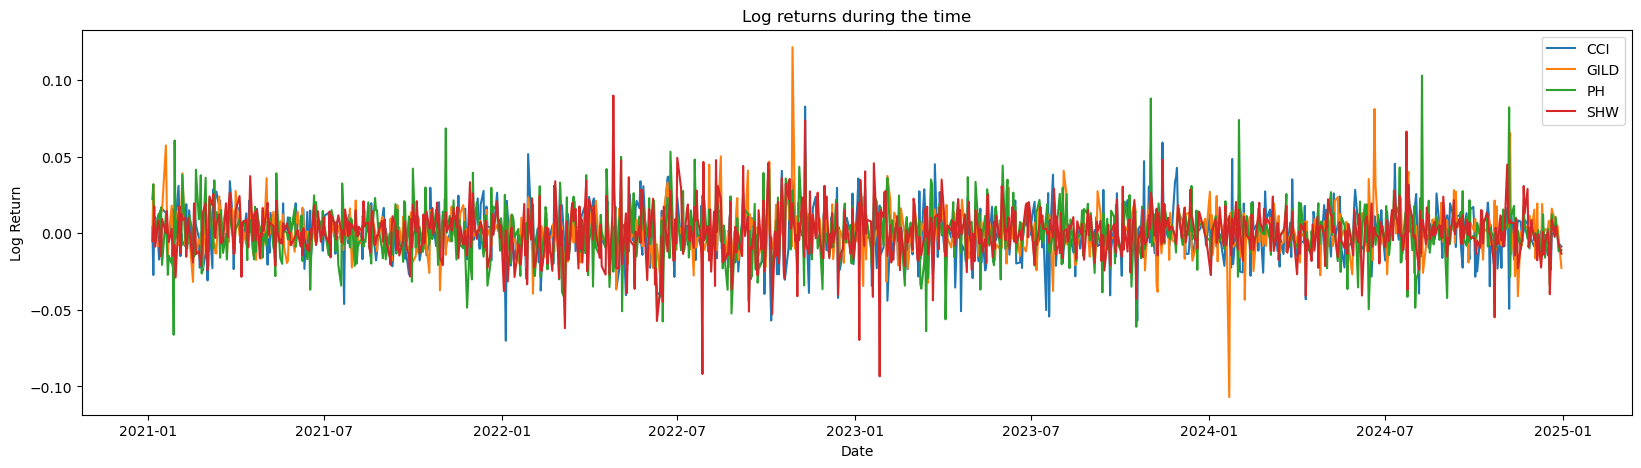

In [227]:
plt.figure(figsize=(20, 5))

for ticker, group in df.groupby("Ticker"):
    plt.plot(group.index, group["log_return"], label=ticker)

plt.legend()
plt.title("Log returns during the time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

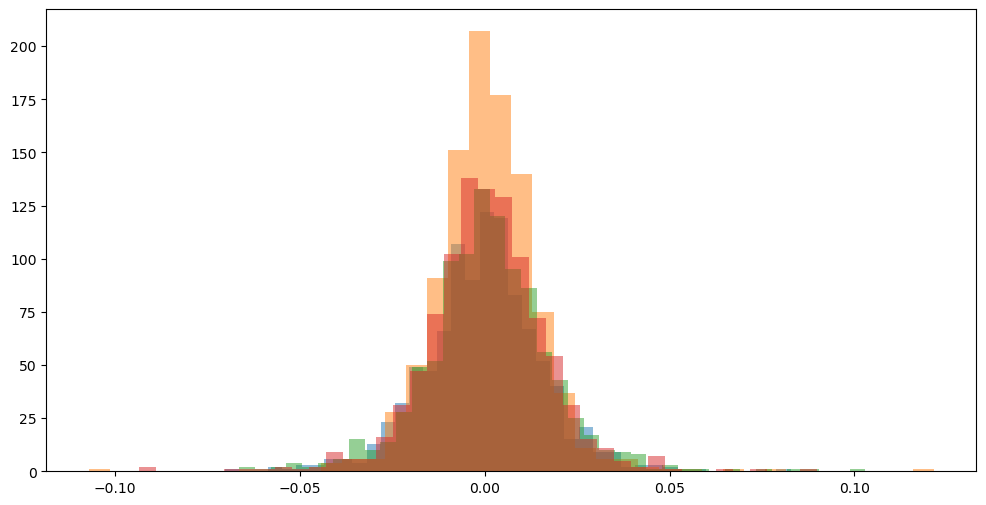

In [229]:
plt.figure(figsize=(12, 6))

for ticker, group in df.groupby("Ticker"):
    plt.hist(group["log_return"].dropna(), bins=40, alpha=0.5, label=ticker)

plt.show()

Problem 2

In [232]:
companies = pd.read_csv(r"C:\Users\obrad\Downloads\companies_no_subindustry.csv")
companies.head()

,Symbol,Security,GICS_Sector,hq,included,Founded
0,MMM,3M,Industrials,"Saint Paul, Minnesota",09.08.1976,1902
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",26.07.2017,1916
2,ABT,Abbott,Health Care,"North Chicago, Illinois",31.03.1964,1888
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",31.12.2012,2013 (1888)
4,ABMD,Abiomed,Health Care,"Danvers, Massachusetts",31.05.2018,1981


In [234]:
missing_included = companies["included"].isna().sum()
missing_included 

np.int64(45)

In [236]:
companies_new = companies[companies['included'].notna()].copy()
companies_new['included'] = pd.to_datetime(companies_new['included'], dayfirst=True, errors='coerce')

In [238]:
companies_new

,Symbol,Security,GICS_Sector,hq,included,Founded
0,MMM,3M,Industrials,"Saint Paul, Minnesota",1976-08-09,1902
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",2017-07-26,1916
2,ABT,Abbott,Health Care,"North Chicago, Illinois",1964-03-31,1888
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",2012-12-31,2013 (1888)
4,ABMD,Abiomed,Health Care,"Danvers, Massachusetts",2018-05-31,1981
...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,"Louisville, Kentucky",1997-10-06,1997
499,ZBRA,Zebra Technologies,Information Technology,"Lincolnshire, Illinois",2019-12-23,1969
500,ZBH,Zimmer Biomet,Health Care,"Warsaw, Indiana",2001-08-07,1927
501,ZION,Zions Bancorporation,Financials,"Salt Lake City, Utah",2001-06-22,1873


In [246]:
oldest = companies_new.loc[data["Founded"] == companies_new["Founded"].min(), "Symbol"]
youngest = companies_new.loc[data["Founded"] == companies_new["Founded"].max(), "Symbol"]

KeyError: 'Founded'

In [159]:
oldest #when i runned again everything it did not work even if I have Founded in dataset

120    CL
Name: Symbol, dtype: object

In [161]:
youngest

481    WBD
Name: Symbol, dtype: object

([<matplotlib.patches.Wedge at 0x1cca651ead0>,
 [Text(0.9824937172637692, 0.4946777693986468, 'Information Technology'),
  Text(0.20256070664599507, 1.0811887717337223, 'Industrials'),
  Text(-0.6908834410715651, 0.8559673304823692, 'Health Care'),
  Text(-1.0941825954625461, 0.11297985566837362, 'Financials'),
  Text(-0.8881412876793592, -0.6490031225805082, 'Consumer Discretionary'),
  Text(-0.3840889062145487, -1.0307646249861855, 'Consumer Staples'),
  Text(0.08292041348479148, -1.096870186041863, 'Real Estate'),
  Text(0.48792744520995873, -0.985863483556868, 'Materials'),
  Text(0.7857795144207144, -0.7697730540339448, 'Communication Services'),
  Text(0.9858638073490111, -0.48792679098335234, 'Utilities'),
  Text(1.0874988240142691, -0.16536719072289333, 'Energy')])

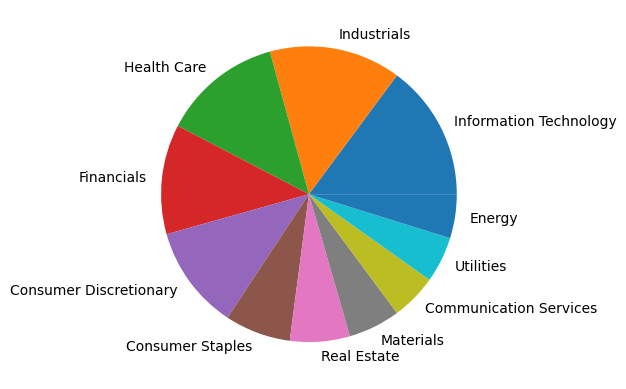

In [242]:
sector = companies_new["GICS_Sector"].value_counts().reset_index()
plt.pie(sector["count"], labels= sector["GICS_Sector"])

In [169]:
companies_new["state"] = companies_new["hq"].str.split(",").str[-1]
states = companies_new["state"].value_counts().reset_index()

<BarContainer object of 38 artists>

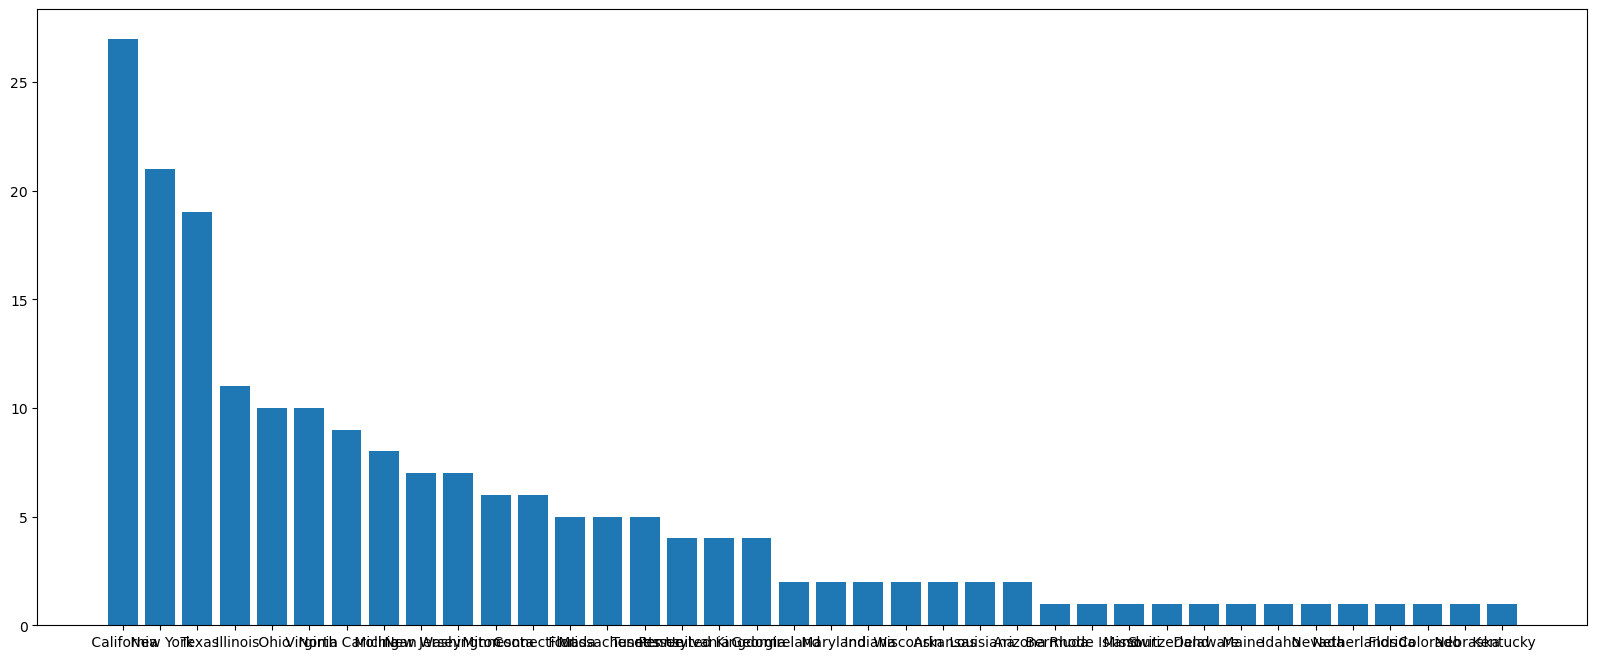

In [244]:
plt.subplots(1,1, figsize = (20,8))
plt.bar(states["state"], states["count"])

Problem 3

In [183]:
np.random.seed(55)
sizes = np.random.randint(100, 501, 4)

In [185]:
data = {
    "Normal": np.random.normal(loc=0, scale=1, size=sizes[0]),
    "Uniform": np.random.uniform(low=0, high=10, size=sizes[1]),
    "Exponential": np.random.exponential(scale=1, size=sizes[2]),
    "Poisson": np.random.poisson(lam=3, size=sizes[3])
}

In [187]:
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))  
df

,Normal,Uniform,Exponential,Poisson
0,0.194458,8.219387,0.527775,4.0
1,-1.608689,0.978591,0.171459,4.0
2,0.712430,0.567372,0.464458,0.0
3,-0.421324,4.921327,1.371452,6.0
4,1.164567,5.253427,0.056847,4.0
...,...,...,...,...
476,NaN,NaN,0.617349,NaN
477,NaN,NaN,0.537257,NaN
478,NaN,NaN,2.189686,NaN
479,NaN,NaN,2.930963,NaN


C:\Users\obrad\AppData\Local\Temp\ipykernel_31948\283265671.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([v for v in data.values()], labels=data.keys())


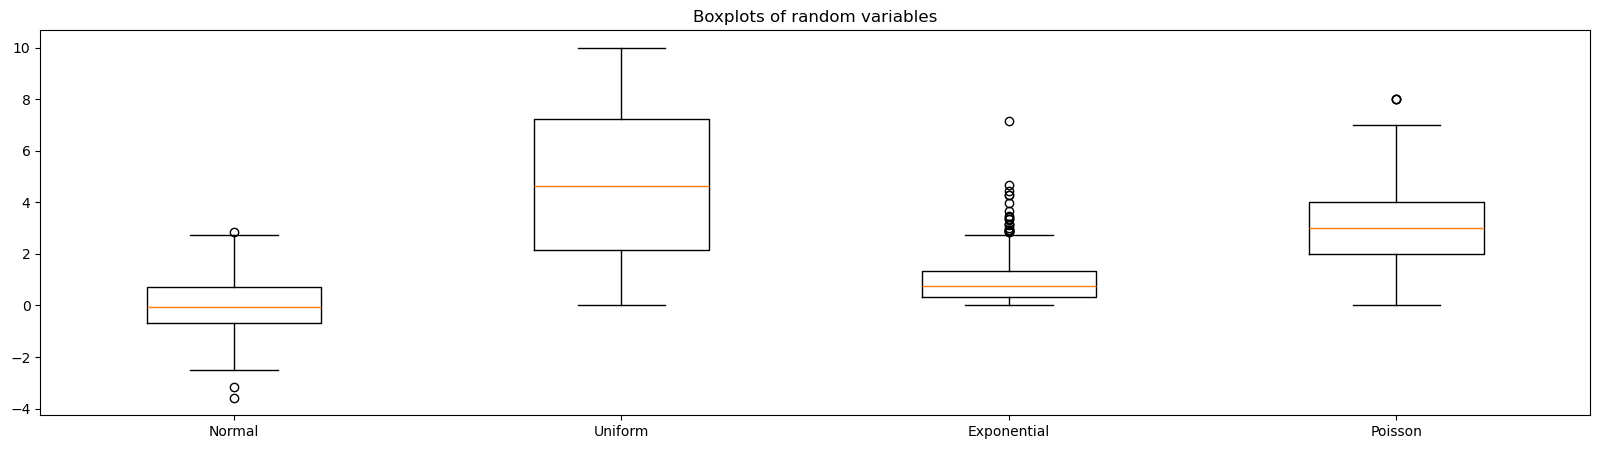

In [189]:
plt.figure(figsize=(20, 5))
plt.boxplot([v for v in data.values()], labels=data.keys())
plt.title("Boxplots of random variables")
plt.show()